In [1]:
import PIL

import numpy as np
import matplotlib.pyplot as plt
import cv2
import gym

# Basic testing of the environment

In [2]:
env_id = 'CarRacing-v0'
env = gym.make(env_id)

C:\Users\vila_\anaconda3\envs\proyecto_rl\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

Track generation: 1124..1409 -> 285-tiles track


## Exploration of observation and action spaces

`step()` returns four values:
- `observation (object)`: observation of the environment. Can vary between environments.
- `reward (float)`: reward achieved by the previous action. Can vary between environments.
- `done (bool)`: wether we finished and should `.reset()` the environment or not.
- `info (dict)`: diagnostic information useful for debugging.

Each timestep, the agent chooses an `action`, and the environment returns an `observation` and a `reward`.

**Note that `reset()` returns the initial observation**

In [4]:
## Get the initial observation
observation = env.reset()

t = 0
while True:
    env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
    t += 1
    
env.close()

Track generation: 1052..1322 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1249..1565 -> 316-tiles track
Episode finished after 1000 timesteps


### Observations

This environments gives 96x96 RGB images as observations. A good approach, as seen in https://notanymike.github.io/Solving-CarRacing/, could be cropping the images to eliminate the bottom row (because it doesn't give the model any info) and turning the images intro gray-scale.

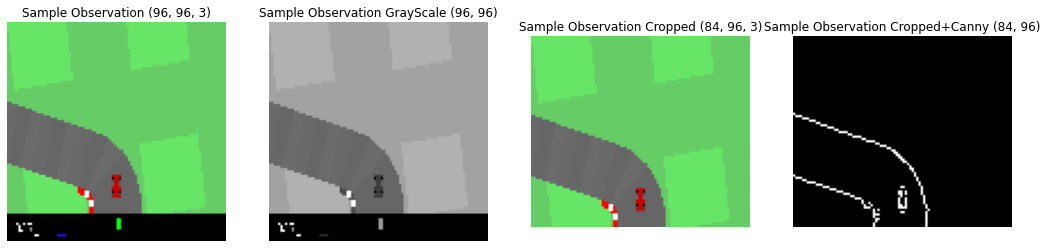

In [41]:
plt.figure(figsize=(18,6))

plt.subplot(1,4,1)
plt.title(f"Sample Observation {observation.shape}")
plt.imshow(observation)
plt.axis('off')

plt.subplot(1,4,2)
observation_gray = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
plt.title(f"Sample Observation GrayScale {observation_gray.shape}")
plt.imshow(observation_gray, cmap="gray")
plt.axis('off')

plt.subplot(1,4,3)
observation_cropped = observation[:-12,:]
plt.title(f"Sample Observation Cropped {observation_cropped.shape}")
plt.imshow(observation_cropped)
plt.axis('off')

plt.subplot(1,4,4)
observation_canny = cv2.Canny(observation_cropped, 100, 200, L2gradient=True)
plt.title(f"Sample Observation Cropped+Canny {observation_canny.shape}")
plt.imshow(observation_canny, cmap='gray')
plt.axis('off')

plt.show()

### Actions

This environment's actions consist of 3 `float32` numbers: 
- Steer $\in$ $[-1,1]$
- Gas $\in$ $[0,1]$
- Brake $\in$ $[0,1]$

They are defined with the `Box` class, which represents a possibly unbounded in $R^n$.

In [69]:
print("Sample action -> Steer: {} | Gas: {} | Brake: {}".format(*env.action_space.sample()))
print("Action Space: ", env.action_space)

Sample action -> Steer: -0.4714801609516144 | Gas: 0.06881653517484665 | Brake: 0.44258904457092285
Action Space:  Box(-1.0, 1.0, (3,), float32)


### Wrapper
We can put the image pre-processing into a `gym.Wrapper` to ease it's use.

In [3]:
class CropObsWrapper(gym.ObservationWrapper):
    """
    We crop the bottom part of the image to remove the part that contains no useful information.
    """
    
    def __init__(self, env):
        super(CropObsWrapper, self).__init__(env)

    def observation(self, observation):
        return observation[:-12,:]

In [4]:
env_w = CropObsWrapper(env)

In [16]:
observation = env_w.reset()
t = 0
while True:
    env_w.render()
    action = env_w.action_space.sample()
    observation, reward, done, info = env_w.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
    t += 1
    
env_w.close()

Track generation: 1099..1378 -> 279-tiles track
Episode finished after 1000 timesteps


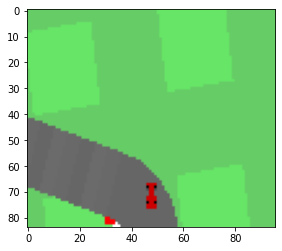

In [17]:
plt.imshow(observation)
plt.show()

In [18]:
class CannyObsWrapper(gym.ObservationWrapper):
    """
    Apply a canny filter to the observations.
    """
    def __init__(self, env):
        super(CannyObsWrapper, self).__init__(env)

    def observation(self, observation):
        return cv2.Canny(observation, 100, 200, L2gradient=True)   

In [19]:
env_c = CannyObsWrapper(env)

In [20]:
observation = env_c.reset()
t = 0
while True:
    env_c.render()
    action = env_c.action_space.sample()
    observation, reward, done, info = env_c.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
    t += 1
    
env_c.close()

Track generation: 1207..1513 -> 306-tiles track
Episode finished after 1000 timesteps


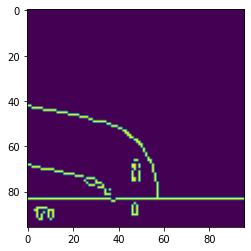

In [21]:
plt.imshow(observation)
plt.show()

### Stacking Wrappers

In [22]:
env_stacked = CropObsWrapper(env)
env_stacked = CannyObsWrapper(env_stacked)

In [23]:
observation = env_stacked.reset()
t = 0
while True:
    env_stacked.render()
    action = env_stacked.action_space.sample()
    observation, reward, done, info = env_stacked.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
    t += 1
    
env_stacked.close()

Track generation: 1219..1528 -> 309-tiles track
Episode finished after 1000 timesteps


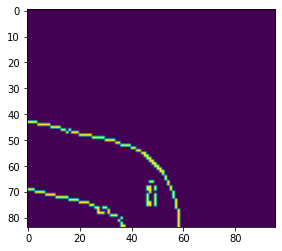

In [24]:
plt.imshow(observation)
plt.show()